In [9]:
# Linear regression using scikit-learn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pumpkins = pd.read_csv('pumpkin.csv')

In [11]:
# Let us focus for the moment only on one pumpkin variety, the 'pie type'
# The code from the repository presents some errors which have been ammended below. The pumpkin file presented NaN values
# in one of the columns used in this example. I have used notna to avoid this error
pumpkins = pumpkins[pumpkins['Package'].notna()]
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()

,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


In [12]:
# We select variety PIE TYPE
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']

In [13]:
# Now we get rid of empty values
pie_pumpkins.dropna(inplace=True)
pie_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 70 to 1630
Data columns (total 8 columns):
Month         144 non-null int64
DayOfYear     144 non-null int64
Variety       144 non-null object
City          144 non-null object
Package       144 non-null object
Low Price     144 non-null float64
High Price    144 non-null float64
Price         144 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 10.1+ KB


C:\Users\imcar\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
"""
Note that we had to perform reshape on the input data in order for the Linear Regression package to understand it correctly. 
Linear Regression expects a 2D-array as an input, where each row of the array corresponds to a vector of input features. 
In our case, since we have only one input - we need an array with shape N×1, where N is the dataset size
"""
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

In [15]:
# Then, we need to split the data into train and test datasets, so that we can validate our model after training:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
# We define the LinearRegression object, and fit it to our data using the fit method to train the model:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
# To see how accurate our model is, we can predict prices on a test dataset. This can be done using mean square error (MSE) metrics
pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

Mean error: 2.77 (17.2%)


In [20]:
# Another indicator of model quality is the coefficient of determination, which can be obtained like this:
score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

Model determination:  0.0446060633502835


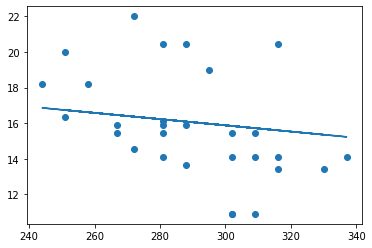

In [21]:
# We can also plot the test data together with the regression line to better see how regression works in our case:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

In [1]:
# POLYNOMIAL REGRESSION
# Polynomial regression creates a curved line to better fit nonlinear data.
"""
    Scikit-learn includes a helpful pipeline API to combine different steps of data processing together. 
    A pipeline is a chain of estimators. 
    In our case, we will create a pipeline that first adds polynomial features to our model, and then trains the regression:
"""

'\n    Scikit-learn includes a helpful pipeline API to combine different steps of data processing together. \n    A pipeline is a chain of estimators. \n    In our case, we will create a pipeline that first adds polynomial features to our model, and then trains the regression:\n'

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280084


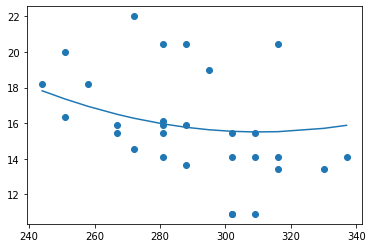

In [23]:
pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

In [24]:
# Categorical Features
# To train linear regression using one-hot encoded variety as input, we just need to initialize X and y data correctly:
pd.get_dummies(new_pumpkins['Variety'])

,FAIRYTALE,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
70,0,0,0,1
71,0,0,0,1
72,0,0,0,1
73,0,0,0,1
74,0,0,0,1
...,...,...,...,...
1738,0,1,0,0
1739,0,1,0,0
1740,0,1,0,0
1741,0,1,0,0


In [25]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

In [26]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    mse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Mean error: 2.47 (9.47%)
Model determination:  0.9376282304455911


In [27]:
# Putting all together
# To make the best model, we can use combined (one-hot encoded categorical + numeric)
# data from the above example together with Polynomial Regression. Here is the complete code for your convenience:

# set up training data
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

# make train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# setup and train the pipeline
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(X_train,y_train)

# predict results for test data
pred = pipeline.predict(X_test)

# calculate MSE and determination
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 1.76 (6.78%)
Model determination:  0.9532504549652583
